In [1]:
__nbid__ = '0001'
__author__ = 'Sylvie Dagoret-Campagne <sylvie.dagoret-campagne@ijclab.in2p3.fr>'
__version__ = '20241229' # yyyymmdd
__datasets__ = ['desi_edr']  
__keywords__ = ['sparcl', 'spectra', 'database']

# Access to DESI Spectra for PZ SED Templates

Inspired from astro datalab Noirlab notebooks

<a class="anchor" id="import"></a>
# Imports

Note in this version we avoid special **desitarget** and **desiutil** tools
We only use **sparcl** to retrieve spectra

In [2]:
## import some helpful python packages 
import numpy as np
import pandas as pd

from astropy.table import Table
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib 
import matplotlib.pyplot as plt

%matplotlib inline

## Data Lab related modules
from sparcl.client import SparclClient
from dl import queryClient as qc, authClient as ac
from getpass import getpass

In [3]:
import astropy.units as u

In [4]:
#F0AB = 3631*(1*u.Jy).cgs.value
F0AB = 3631*(1*u.Jy)

<a class="anchor" id="auth"></a>
# Authentication
If you need to log in to Data Lab, un-comment the cell below and execute it:

In [5]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
ac.whoAmI()

'sdagoret'

In [6]:
## Making the matplotlib plots look nicer
settings = {
    'font.size':22,
    'axes.linewidth':3.0,
    'xtick.major.size':6.0,
    'xtick.minor.size':4.0,
    'xtick.major.width':3.0,
    'xtick.minor.width':1.5,
    'xtick.direction':'in', 
    'xtick.minor.visible':True,
    'xtick.top':True,
    'ytick.major.size':6.0,
    'ytick.minor.size':4.0,
    'ytick.major.width':3.0,
    'ytick.minor.width':1.5,
    'ytick.direction':'in', 
    'ytick.minor.visible':True,
    'ytick.right':True
}

plt.rcParams.update(**settings)

In [7]:
## Instantiate SPARCL Client
client = SparclClient()

<a class="anchor" id="desi_edr"></a>
# DESI EDR database

The `desi_edr` database schema at Data Lab consists of several tables associated with the targets.

In [8]:
print(qc.schema('desi_edr'))


Schema: desi_edr

      Table Name   Description
      ----------   -----------
        exposure   Summary quantities for every DESI exposure
     fiberassign   Quantities obtained when a DESI target is assigned to a fiber
           frame   Summary quantities for each petal of the DESI instrument i
                   n a given exposure; in normal operation there are ten fram
                   es for every exposure
      photometry   Photometric quantities from LS DR9 for every TARGETID
       potential   For a given tile, this table lists all targets that could 
                   have received a fiber assignment
          target   The quantities obtained when photometric objects are analy
                   zed in the target selection process
            tile   Summary quantities for every DESI tile (pointing on the sky)
x1p5__zpix__allwise__source   desi_edr.zpix and xmatch_std.allwise__source crossmatch (1
                   .5 arcsec)
x1p5__zpix__gaia_dr3__gaia_source   desi_edr

We focus on the `photometry` and `zpix` table in this notebook, which is the main redshift catalog from the DESI survey. It contains the redshift information from the coadded-spectra, based on the healpix of the objects.

We look at the available columns in this table.

### Photometry table

In [9]:
## Columns in the photometry table
print(qc.schema('desi_edr.photometry'))


Schema: desi_edr
 Table: photometry

     Column Name   Description
     -----------   -----------
              ra   Right ascension
             dec   Declination
            elon   Ecliptic longitude
            elat   Ecliptic latitude
            glon   Galactic longitude
            glat   Galactic latitude
           ls_id   Unique Legacy Survey object ID
          ref_id   Tyc1*1000000+Tyc2*10+Tyc3 for Tycho-2; sourceid for Gaia DR2
        targetid   Unique DESI target ID
         ra_ivar   Right ascension inverse variance
        dec_ivar   Declination inverse variance
      dchisq_psf   Difference in chi-squared between PSF (stellar) Tractor mo
                   del fits
      dchisq_rex   Difference in chi-squared between REX (round exponential g
                   alaxy) Tractor model fits
      dchisq_dev   Difference in chi-squared between DEV (deVauc) Tractor mod
                   el fits
      dchisq_exp   Difference in chi-squared between EXP (exponential) Tracto
 

### zpix table

In [10]:
## Columns in the zpix table
print(qc.schema('desi_edr.zpix'))


Schema: desi_edr
 Table: zpix

     Column Name   Description
     -----------   -----------
 tsnr2_gpbdark_r   GPBDARK R template (S/N)^2
     tsnr2_elg_r   ELG R template (S/N)^2
tsnr2_gpbbright_r   GPBBRIGHT R template (S/N)^2
     tsnr2_lya_r   LYA R template (S/N)^2
               z   Redshift measured by Redrock
            zerr   Redshift error from Redrock
            chi2   Best fit chi squared
         coeff_0   Redrock template coefficients
         coeff_1   Redrock template coefficients
         coeff_2   Redrock template coefficients
         coeff_3   Redrock template coefficients
         coeff_4   Redrock template coefficients
         coeff_5   Redrock template coefficients
         coeff_6   Redrock template coefficients
         coeff_7   Redrock template coefficients
         coeff_8   Redrock template coefficients
         coeff_9   Redrock template coefficients
       deltachi2   Delta-chi-squared for template fit from Redrock
   mean_fiber_ra   Mean (over expos

<a class="anchor" id="desi_target_access"></a>
# Accessing DESI targets

The DESI spectra are uniquely identified by three quantities:

* **targetid**: unique identifier for a given target
* **survey**: SURVEY that the target was observed in. This can be _cmx_, _special_, _sv1_, _sv2_, or _sv3_.
* **program**: FIBER ASSIGNMENT PROGRAM. This is the planned observing conditions for the target. It can be _dark_ or _bright_ or _backup_. In case of _cmx_ and _sv1_, there is _other_ as well.
    
The different spectra of individual targets are coadded within each survey and program. Therefore, some targets may have multiple coadded spectra and each one is associated with a given `targetid`, `survey`, and `program`. The "best" spectrum for a given object is given by the `zcat_primary` column. More information about the data model of the redshift catalogs is available [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zpix-SURVEY-PROGRAM.html#).

In [11]:
#eg. SELECT (column_1, column_2, ... column_n) FROM T1 JOIN T2 ON (condition) WHERE (condition)

To select in two tables

```
SELECT t1.id, t1.ra, t1.dec, t2.mag, t2.band
FROM catalog.table1 AS t1
JOIN catalog.table2 AS t2 ON t1.id = t2.id
WHERE CONTAINS(POINT('IRCS', t1.ra, t1.dec), CIRCLE('ICRS', 62.123, -37.456 0.002)) = 1
```

In [12]:
query = """
SELECT zp.targetid, zp.survey, zp.program, zp.healpix,  
       zp.z, zp.zwarn, zp.coadd_fiberstatus, zp.spectype, 
       zp.mean_fiber_ra, zp.mean_fiber_dec, zp.zcat_nspec, 
       CAST(zp.zcat_primary as int), zp.desi_target,
       zp.sv1_desi_target, zp.sv2_desi_target, zp.sv3_desi_target
FROM desi_edr.zpix AS zp
""" 

## Information about the query
## Selected columns --
## targetid, survey, program -- unique identifiers for a given spectrum
## healpix -- healpix number for the target
## z -- spectroscopic redshift of the target
## zwarn -- encoded information regarding the redshift (zwarn = 0 is good)
## coadd_fiberstatus -- encoded information regarding the fiber that is assigned to the target (coadd_fiberstatus = 0 is good)
## spectype -- Spectral type of the target: STAR | GALAXY | QSO
## mean_fiber_ra, mean_fiber_dec -- Mean R.A. and Dec. of the fiber position from all the observations of the target
## zcat_nspec -- Number of coadded spectra that are available for a given target
## zcat_primary -- Whether or not a given coadded spectrum is the primary spectrum. zcat_primary = True for the "best" spectrum.
## CASTing this column as an INT: zcat_primary = 1 for the "best" spectrum.
## desi_target -- encodes main survey's DESI targeting information - explained in detail below
## sv1_desi_target -- encodes sv1 desi targeting information
## sv2_desi_target -- encodes sv2 desi targeting information
## sv3_desi_target -- encodes sv3 desi targeting information

In [13]:
query = """
SELECT zp.targetid, zp.survey, zp.program, zp.healpix,  
       zp.z, zp.zwarn, zp.coadd_fiberstatus, zp.spectype, 
       zp.mean_fiber_ra, zp.mean_fiber_dec, zp.zcat_nspec, 
       CAST(zp.zcat_primary as int), zp.desi_target,
       zp.sv1_desi_target, zp.sv2_desi_target, zp.sv3_desi_target,
       ph.ra,ph.dec, ph.morphtype,
       ph.flux_g,ph.flux_r, ph.flux_z, ph.flux_ivar_g, ph.flux_ivar_r,ph.flux_ivar_z,
       ph.flux_w1, ph.flux_w2, ph.flux_w3, ph.flux_w4, 
       ph.flux_ivar_w1, ph.flux_ivar_w2, ph.flux_ivar_w3, ph.flux_ivar_w4   
FROM desi_edr.zpix AS zp JOIN desi_edr.photometry AS ph ON (zp.targetid = ph.targetid)
""" 

In [14]:
print(query)


SELECT zp.targetid, zp.survey, zp.program, zp.healpix,  
       zp.z, zp.zwarn, zp.coadd_fiberstatus, zp.spectype, 
       zp.mean_fiber_ra, zp.mean_fiber_dec, zp.zcat_nspec, 
       CAST(zp.zcat_primary as int), zp.desi_target,
       zp.sv1_desi_target, zp.sv2_desi_target, zp.sv3_desi_target,
       ph.ra,ph.dec, ph.morphtype,
       ph.flux_g,ph.flux_r, ph.flux_z, ph.flux_ivar_g, ph.flux_ivar_r,ph.flux_ivar_z,
       ph.flux_w1, ph.flux_w2, ph.flux_w3, ph.flux_w4, 
       ph.flux_ivar_w1, ph.flux_ivar_w2, ph.flux_ivar_w3, ph.flux_ivar_w4   
FROM desi_edr.zpix AS zp JOIN desi_edr.photometry AS ph ON (zp.targetid = ph.targetid)



In [15]:
zpix = qc.query(sql = query, fmt = 'table')

In [16]:
print(f"The resulting table has {len(zpix)} rows")
zpix[0:5]

The resulting table has 2044588 rows


targetid,survey,program,healpix,z,zwarn,coadd_fiberstatus,spectype,mean_fiber_ra,mean_fiber_dec,zcat_nspec,zcat_primary,desi_target,sv1_desi_target,sv2_desi_target,sv3_desi_target,ra,dec,morphtype,flux_g,flux_r,flux_z,flux_ivar_g,flux_ivar_r,flux_ivar_z,flux_w1,flux_w2,flux_w3,flux_w4,flux_ivar_w1,flux_ivar_w2,flux_ivar_w3,flux_ivar_w4
int64,str7,str6,int64,float64,int64,int64,str6,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
6432023904256,sv1,dark,28473,-0.0019956912923479522,1570,512,STAR,179.44762,27.676514,1,1,0,4611686018427387904,0,0,179.44416,27.6589,--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6448025174016,sv1,dark,28478,0.022190569941649994,0,0,GALAXY,179.1566,28.423487,1,1,0,4611686018427387904,0,0,179.15657,28.4234799,--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6515536691200,sv1,dark,4958,0.5364068034833155,4,0,GALAXY,142.94812,31.824783,1,1,0,4611686018427387904,0,0,142.94811,31.82478,--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6521555517440,sv1,dark,10436,0.010017642879535897,0,0,GALAXY,204.2275,32.094933,1,1,0,4611686018427387904,0,0,204.22749,32.09493,--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6536638234624,sv1,dark,28534,0.07641158065394126,0,0,GALAXY,186.27412,32.84502,1,1,0,4611686018427387904,0,0,186.274119,32.84503,--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Check how many rows have unique TARGETIDs before/after applying the ZCAT_PRIMARY flag
print(f"Total N(rows) : {len(zpix)}")
print(f"N(rows) with unique TARGETIDs : {len(np.unique(zpix['targetid']))}")

is_primary = (zpix['zcat_primary']==1)

print(f"N(rows) with ZCAT_PRIMARY=True : {len(zpix[is_primary])}")

Total N(rows) : 2044588
N(rows) with unique TARGETIDs : 1979269
N(rows) with ZCAT_PRIMARY=True : 1979269


In [18]:
## Selecting only unique objects
zpix_cat = zpix[is_primary]

In [19]:
type(zpix_cat)

astropy.table.table.Table

In [20]:
df = zpix_cat.to_pandas()

In [21]:
df.describe()

,targetid,healpix,z,zwarn,coadd_fiberstatus,mean_fiber_ra,mean_fiber_dec,zcat_nspec,zcat_primary,desi_target,...,flux_ivar_r,flux_ivar_z,flux_w1,flux_w2,flux_w3,flux_w4,flux_ivar_w1,flux_ivar_w2,flux_ivar_w3,flux_ivar_w4
count,1.979269e+06,1.979269e+06,1.979269e+06,1.979269e+06,1.979269e+06,1.979269e+06,1.979269e+06,1.979269e+06,1979269.0,1.979269e+06,...,1.979269e+06,1.979269e+06,1.979269e+06,1.979269e+06,1.979269e+06,1.979269e+06,1.979269e+06,1.979269e+06,1.979269e+06,1.979269e+06
mean,1.550168e+17,1.581521e+04,5.171485e-01,9.856214e+01,2.387955e+05,1.954990e+02,3.041136e+01,1.033002e+00,1.0,1.978282e+16,...,1.896657e+02,5.697428e+01,5.595829e+01,4.999907e+01,3.791464e+01,7.232810e+01,3.403558e+00,1.054840e+00,4.609147e-03,5.502543e-05
std,4.987671e+17,8.719754e+03,5.758931e-01,3.857738e+02,1.437785e+07,5.341941e+01,2.520166e+01,1.886333e-01,0.0,2.948496e+17,...,2.213262e+02,4.513832e+01,1.067184e+04,2.358683e+04,7.256406e+02,4.392629e+03,1.904642e+00,9.402610e-01,1.730217e-02,2.006256e-04
min,6.432024e+12,6.830000e+02,-5.000000e-03,0.000000e+00,0.000000e+00,2.413598e+00,-3.160238e+01,1.000000e+00,1.0,0.000000e+00,...,-9.900000e+01,-9.900000e+01,-7.369398e+04,-6.415370e+04,-3.011907e+04,-1.250068e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.962785e+16,9.431000e+03,4.912182e-05,0.000000e+00,0.000000e+00,1.730003e+02,2.329435e+00,1.000000e+00,1.0,0.000000e+00,...,5.773481e+01,2.474602e+01,3.113652e+00,2.699172e+00,-1.618818e+01,-3.097677e+02,2.305816e+00,6.123157e-01,9.206284e-04,1.212728e-05
50%,3.963295e+16,1.123100e+04,3.006546e-01,0.000000e+00,0.000000e+00,2.090377e+02,3.299155e+01,1.000000e+00,1.0,0.000000e+00,...,1.275913e+02,4.688059e+01,1.848211e+01,1.266778e+01,1.011403e+01,1.446612e+01,3.055959e+00,7.587050e-01,1.438069e-03,1.903950e-05
75%,3.963332e+16,2.596700e+04,9.088130e-01,0.000000e+00,0.000000e+00,2.354590e+02,5.272584e+01,1.000000e+00,1.0,0.000000e+00,...,2.445051e+02,7.956982e+01,4.898040e+01,3.156832e+01,4.942154e+01,3.871453e+02,4.042931e+00,1.203593e+00,2.456033e-03,2.869740e-05
max,2.305843e+18,4.500700e+04,5.993195e+00,3.746000e+03,1.077937e+09,3.578248e+02,8.460914e+01,5.000000e+00,1.0,8.070451e+18,...,3.956942e+03,5.398738e+02,1.463032e+07,3.270460e+07,8.131639e+05,4.917560e+06,2.082350e+01,1.115424e+01,3.504970e-01,3.751689e-03


### remove unknown mags and select galaxies only

In [22]:
cut = (df.flux_g == 0) | (df.flux_r == 0) | (df.flux_z == 0) |  (df.flux_w1 == 0) | (df.flux_w2 == 0)
df = df.drop(df[cut].index)

In [23]:
df = df[df.spectype == "GALAXY"]

### Convert fluxes in AB magnitudes
- reference on the Legacy Survey here : https://www.legacysurvey.org/dr8/description/

- a flux of 1 nanomaggie corresponds to an AB magnitude of 22.5.
- A source with a spectrum of 𝑓 = 10^( − (48.6 + 22.5)/2.5) erg/s/cm²/Hz would be reported to have an integrated flux of 1 nanomaggie in any filter
- a flux of one maggies is constant in erg/s/cm²/Hz

In [24]:
#dm = -2.5 / log(10) * 1/(sqrt(ivar)*f)
error_factor = 2.5/np.log(10)

In [25]:
# assuming the flux in in Jy
#df["mag_g"] = df["flux_g"].apply(lambda x : (x*u.Jy).to_value(u.ABmag))
#df["mag_r"] = df["flux_r"].apply(lambda x : (x*u.Jy).to_value(u.ABmag))
#df["mag_z"] = df["flux_z"].apply(lambda x : (x*u.Jy).to_value(u.ABmag))

# assuming the flux is in nanomaggies
#df["mag_g"] = df["flux_g"].apply(lambda x : 22.5 - 2.5*np.log10(x))
#df["mag_r"] = df["flux_r"].apply(lambda x : 22.5 - 2.5*np.log10(x))
#df["mag_z"] = df["flux_z"].apply(lambda x : 22.5 - 2.5*np.log10(x))

# assuming the flux is in maggies (erg/s/cm²/Hz)
df["mag_g"] = df["flux_g"].apply(lambda x : (x*u.erg/u.s/(u.cm)**2/u.Hz).to_value(u.ABmag) + 48.6 + 22.5)
df["mag_r"] = df["flux_r"].apply(lambda x : (x*u.erg/u.s/(u.cm)**2/u.Hz).to_value(u.ABmag) + 48.6 + 22.5)
df["mag_z"] = df["flux_z"].apply(lambda x : (x*u.erg/u.s/(u.cm)**2/u.Hz).to_value(u.ABmag) + 48.6 + 22.5)

/Users/dagoret/anaconda3/envs/conda_py311/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:66: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dagoret/anaconda3/envs/conda_py311/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:66: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/Users/dagoret/anaconda3/envs/conda_py311/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:66: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [26]:
df["mag_g_err"] = df[["flux_g","flux_ivar_g"]].apply(lambda x : error_factor/x[0]/np.sqrt(x[1]),raw=True,axis=1)
df["mag_r_err"] = df[["flux_r","flux_ivar_r"]].apply(lambda x : error_factor/x[0]/np.sqrt(x[1]),raw=True,axis=1)
df["mag_z_err"] = df[["flux_z","flux_ivar_z"]].apply(lambda x : error_factor/x[0]/np.sqrt(x[1]),raw=True,axis=1)

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_18462/30555484.py:1: RuntimeWarning: divide by zero encountered in scalar divide
  df["mag_g_err"] = df[["flux_g","flux_ivar_g"]].apply(lambda x : error_factor/x[0]/np.sqrt(x[1]),raw=True,axis=1)
/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_18462/30555484.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  df["mag_r_err"] = df[["flux_r","flux_ivar_r"]].apply(lambda x : error_factor/x[0]/np.sqrt(x[1]),raw=True,axis=1)
/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_18462/30555484.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  df["mag_z_err"] = df[["flux_z","flux_ivar_z"]].apply(lambda x : error_factor/x[0]/np.sqrt(x[1]),raw=True,axis=1)


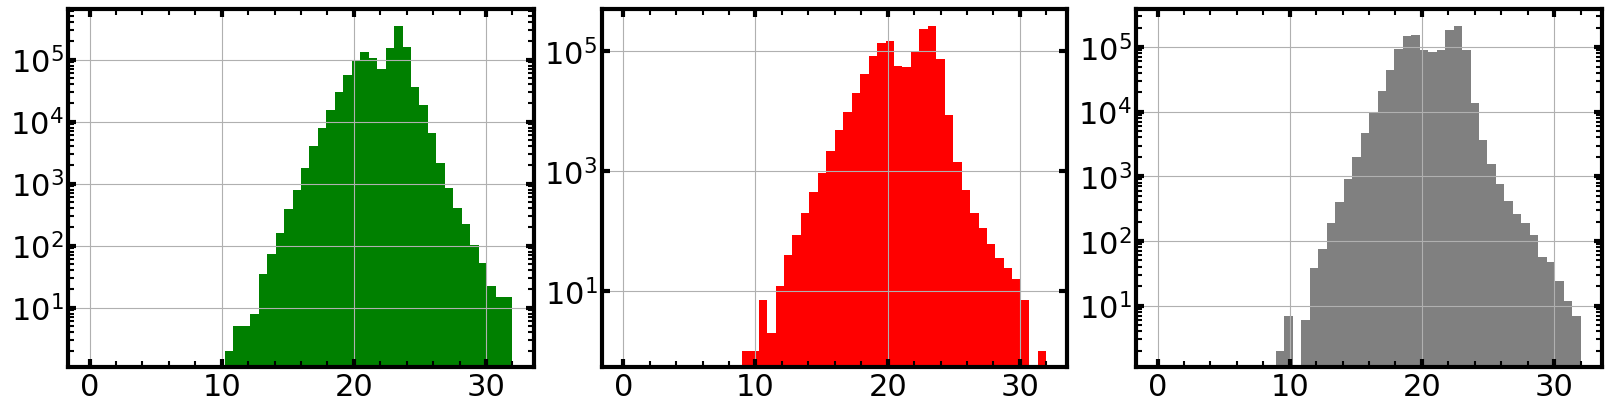

In [27]:
fig,axs = plt.subplots(1,3,figsize=(16,4),layout="constrained")
ax1,ax2,ax3 = axs.flatten()
df["mag_g"].hist(bins=50,range=(0,32),ax=ax1,facecolor="g")
ax1.set_yscale("log")
df["mag_r"].hist(bins=50,range=(0,32),ax=ax2,facecolor="r")
ax2.set_yscale("log")
df["mag_z"].hist(bins=50,range=(0,32),ax=ax3,facecolor="grey")
ax3.set_yscale("log")

(0.0, 0.1)

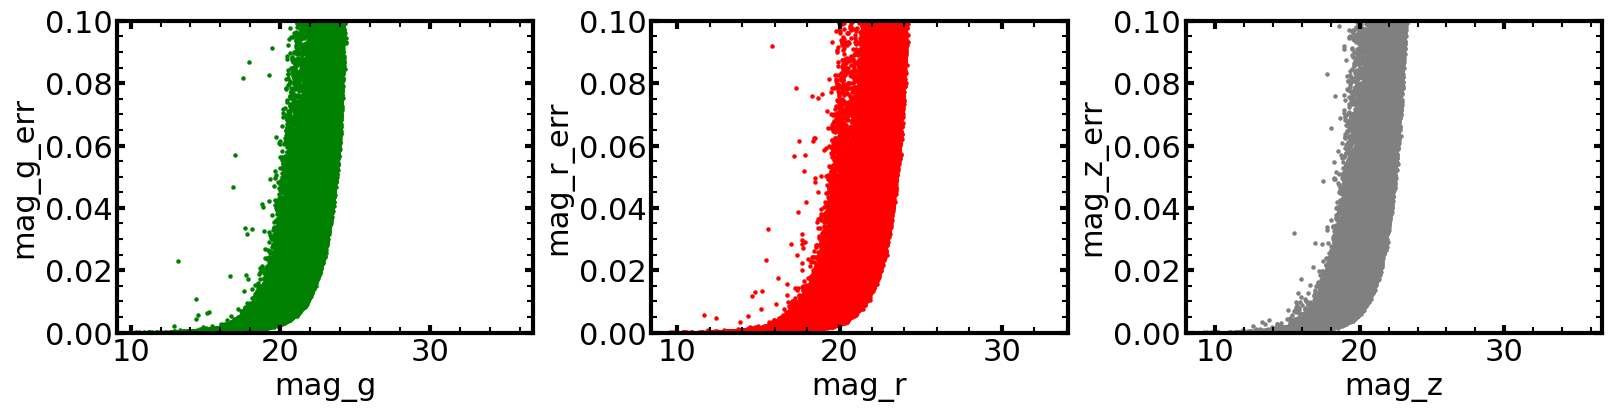

In [28]:
fig,axs = plt.subplots(1,3,figsize=(16,4),layout="constrained")
ax1,ax2,ax3 = axs.flatten()
df.plot.scatter(x="mag_g",y="mag_g_err",ax=ax1,marker=".",color="g")
df.plot.scatter(x="mag_r",y="mag_r_err",ax=ax2,marker=".",color="r")
df.plot.scatter(x="mag_z",y="mag_z_err",ax=ax3,marker=".",color="grey")

ax1.set_ylim(0,0.1)
ax2.set_ylim(0,0.1)
ax3.set_ylim(0,0.1)

<a class="anchor" id="target_info"></a>
## Selecting sources based on targeting information

DESI targets are divided into five main classes:
* MWS: Milky Way Survey - This survey probes "stars" in the Milky Way.
* BGS: Bright Galaxy Survey - This survey probes the bright galaxies in the nearby universe.
* LRG: Luminous Red Galaxies
* ELG: Emission Line Galaxies
* QSO: Quasars

[Myers et al. 2023](https://ui.adsabs.harvard.edu/abs/2023AJ....165...50M/abstract) describe the target selection and information in more detail. Apart from these main classes, there are also secondary fiber targets that are based on different secondary programs in DESI (SCND targets).

The `*DESI_TARGET` columns encode the information related to which class the target belongs to. Note that some sources can be part of different classes. 

In this section, we show how to select sources based on their targeting information.

The information about different target bits is available [here](https://desidatamodel.readthedocs.io/en/latest/bitmasks.html#target-masks). By using the target bits directly, we avoid the usage of targetmasks that come from DESI software.

In [29]:
## Function to check the bits
def check_bits(table, bit):
    """
    Function to check the bits corresponding to the main target classes.

    Parameters
    ----------
    table : astropy table
        Table of DESI targets with required sv*desi_target columns
        
    bit : int
        Target bit from DESI

    Returns
    -------
    res : numpy array
        Boolean array corresponding to the bit
    """
    # Targeting information about the DESI targeting is stored in the different desi_target columns
    sv1_desi_tgt = table['sv1_desi_target']
    sv2_desi_tgt = table['sv2_desi_target']
    sv3_desi_tgt = table['sv3_desi_target']
        
    val = (2**bit)
    res = (sv1_desi_tgt & val != 0)|(sv2_desi_tgt & val != 0)|(sv3_desi_tgt & val != 0)

    return (res)

In [30]:
## Function to check the bits
def check_bits_pddf(row):
    """
    Function to check the bits corresponding to the main target classes.

    Parameters
    ----------
    table : astropy table
        Table of DESI targets with required sv*desi_target columns
        
    bit : int
        Target bit from DESI global variable

    Returns
    -------
    res : numpy array
        Boolean array corresponding to the bit
    """
    # Targeting information about the DESI targeting is stored in the different desi_target columns
    sv1_desi_tgt = row['sv1_desi_target']
    sv2_desi_tgt = row['sv2_desi_target']
    sv3_desi_tgt = row['sv3_desi_target']
        
    val = (2**bit)
    res = (sv1_desi_tgt & val != 0)|(sv2_desi_tgt & val != 0)|(sv3_desi_tgt & val != 0)

    return (res)

In [31]:
## Selecting candidates - 
## Target bits from DESI:
## 1. BGS: bit 60
## 2. LRG: bit 0
## 3. ELG: bit 1
## 4. QSO: bit 2
## 5. MWS: bit 61
## 6. Secondary Targets: bit 62

is_bgs = check_bits(zpix_cat, 60)
is_lrg = check_bits(zpix_cat, 0)
is_elg = check_bits(zpix_cat, 1)
is_qso = check_bits(zpix_cat, 2)
is_mws = check_bits(zpix_cat, 61)
is_scnd = check_bits(zpix_cat, 62)

In [32]:
# Number of sources of each target type
n_bgs = len(zpix_cat[is_bgs])
n_lrg = len(zpix_cat[is_lrg])
n_elg = len(zpix_cat[is_elg])
n_qso = len(zpix_cat[is_qso])
n_mws = len(zpix_cat[is_mws])
n_scnd = len(zpix_cat[is_scnd])

In [73]:
# Let us look at the numbers visually - 

plt.figure(figsize = (8,6))

targets = ['BGS', 'LRG', 'ELG', 'QSO', 'MWS', 'SCND']
numbers = [n_bgs, n_lrg, n_elg, n_qso, n_mws, n_scnd]

#plt.bar(targets, numbers, color = 'purple', alpha = 0.5)
#plt.ylabel('Number of primary spectra')
#plt.yscale('log')

<Figure size 800x600 with 0 Axes>

In [34]:
# MWS: Milky Way Survey (all false by constrution
bit = 61
df['MWS'] = df.apply(check_bits_pddf,axis=1)
#BGS: Bright Galaxy Survey
bit = 60
df['BGS'] = df.apply(check_bits_pddf,axis=1)
# LRG: Luminous Red Galaxies
bit = 0
df['LRG'] = df.apply(check_bits_pddf,axis=1)
# ELG: Emission Line Galaxies
bit = 1
df['ELG'] = df.apply(check_bits_pddf,axis=1)
# QSO : Quasars
bit = 2
df['QSO'] = df.apply(check_bits_pddf,axis=1)
# Secondary Targets
bit = 62
df['SCND'] = df.apply(check_bits_pddf,axis=1)

In [41]:
df_target = df[targets]

In [46]:
df_target_sum = df_target.sum()
df_target_sum 

BGS     433666
LRG     226454
ELG     521602
QSO      91848
MWS       6720
SCND     80374
dtype: int64

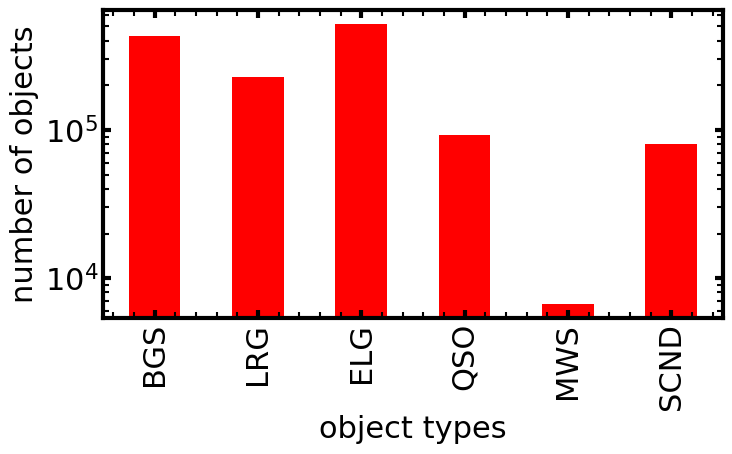

In [70]:
import matplotlib.ticker as mtick

fig,ax = plt.subplots(1,1,figsize = (8,4))
df_target_sum.plot.bar(ax=ax,facecolor="r",xlabel="object types",ylabel="number of objects")
logfmt = mtick.LogFormatterExponent(base=10.0, labelOnlyBase=False) 
ax.yaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
ax.set_yscale('log')

Text(0.5, 0, 'Redshift')

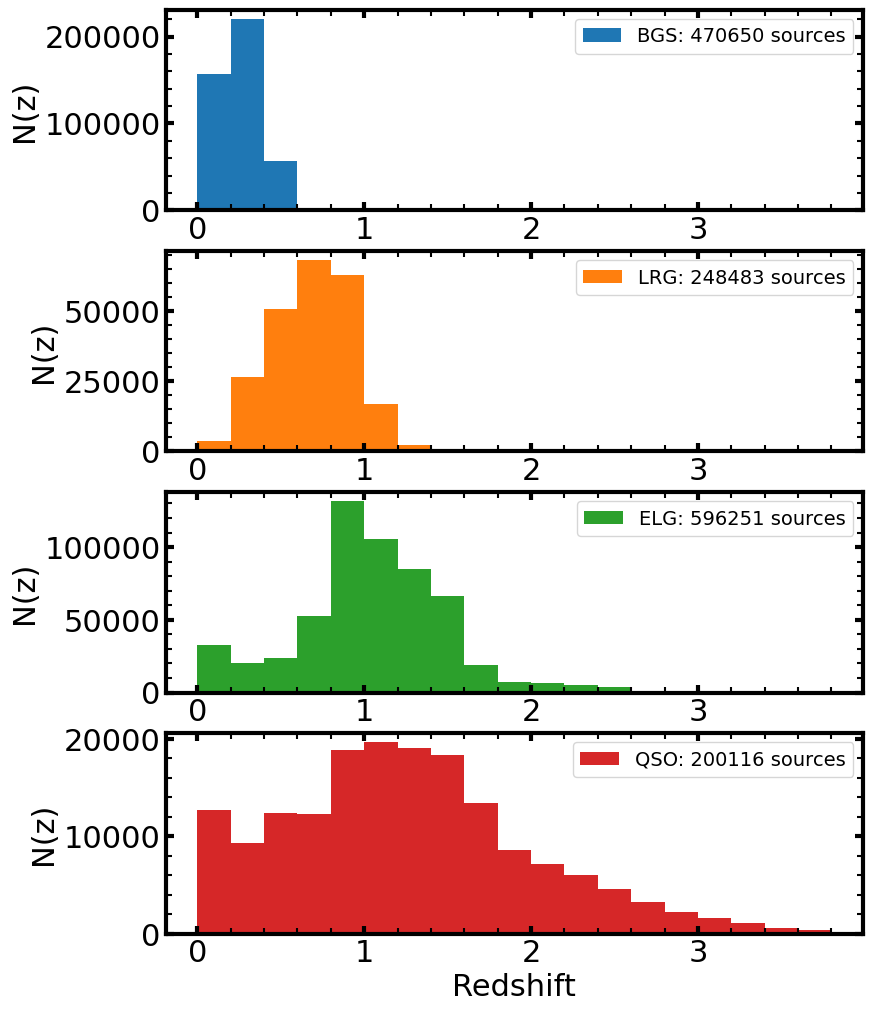

In [74]:
# Now let us look at the distribution of redshifts -

fig, axs = plt.subplots(4, 1, figsize = (9, 12))
bins = np.arange(0, 4, 0.2)

axs[0].hist(zpix_cat['z'][is_bgs], color = 'C0', bins = bins, label = f'BGS: {n_bgs} sources')
axs[0].legend(fontsize = 14)
axs[0].set_ylabel("N(z)")
axs[1].hist(zpix_cat['z'][is_lrg], color = 'C1', bins = bins, label = f'LRG: {n_lrg} sources')
axs[1].legend(fontsize = 14)
axs[1].set_ylabel("N(z)")
axs[2].hist(zpix_cat['z'][is_elg], color = 'C2', bins = bins, label = f'ELG: {n_elg} sources')
axs[2].legend(fontsize = 14)
axs[2].set_ylabel("N(z)")
axs[3].hist(zpix_cat['z'][is_qso], color = 'C3', bins = bins, label = f'QSO: {n_qso} sources')
axs[3].legend(fontsize = 14)
axs[3].set_ylabel("N(z)")
axs[3].set_xlabel("Redshift")


Text(0.5, 0, 'Redshift')

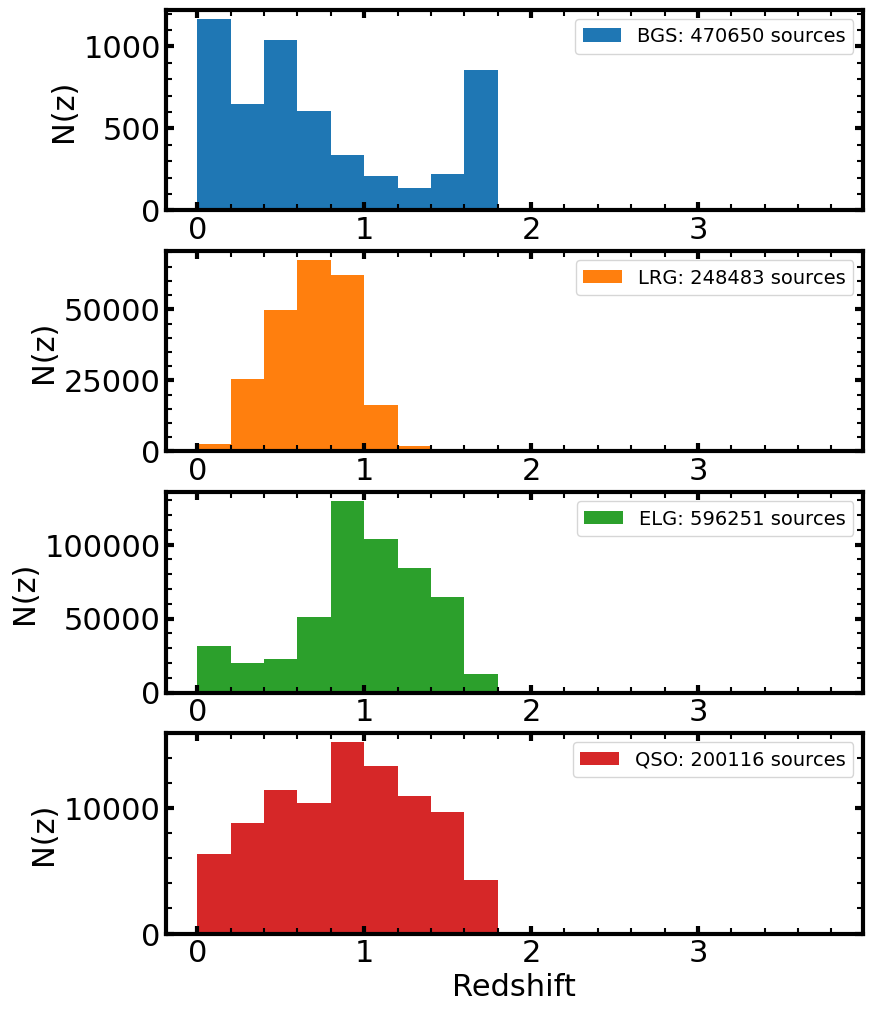

In [76]:
# Now let us look at the distribution of redshifts -

fig, axs = plt.subplots(4, 1, figsize = (9, 12))
bins = np.arange(0, 4, 0.2)

axs[0].hist(df[df['MWS']].z, color = 'C0', bins = bins, label = f'BGS: {n_bgs} sources')
axs[0].legend(fontsize = 14)
axs[0].set_ylabel("N(z)")
axs[1].hist(df[df['LRG']].z, color = 'C1', bins = bins, label = f'LRG: {n_lrg} sources')
axs[1].legend(fontsize = 14)
axs[1].set_ylabel("N(z)")
axs[2].hist(df[df['ELG']].z, color = 'C2', bins = bins, label = f'ELG: {n_elg} sources')
axs[2].legend(fontsize = 14)
axs[2].set_ylabel("N(z)")
axs[3].hist(df[df['QSO']].z, color = 'C3', bins = bins, label = f'QSO: {n_qso} sources')
axs[3].legend(fontsize = 14)
axs[3].set_ylabel("N(z)")
axs[3].set_xlabel("Redshift")

### Other masks

The `SV*_DESI_TARGET` columns consists of the uppermost level targeting information in DESI. However, there are sub-classes of targets. <br/>
For example, BGS have different target masks depending on the selection criterion. Each of the different secondary target proposals have their own masks. They can be selected in a similar way as above, but with the respective columns (like `SV1_BGS_TARGET` or `SV1_SCND_TARGET` in the `target` table. More information about Bitmasks in DESI is available [here](https://desidatamodel.readthedocs.io/en/latest/bitmasks.html).

<a class="anchor" id="spectra_access"></a>
# Accessing and plotting the spectra of a given object

Finally, we show how to access all the available healpix-coadded spectra of a given object. We also show how to select the "best" spectrum.  
We use SPARCL, which is a fast spectral access service at Data Lab.  
Detailed ways to using SPARCL are available in this [notebook](https://github.com/astro-datalab/notebooks-latest/blob/master/04_HowTos/SPARCL/How_to_use_SPARCL.ipynb).

In [77]:
## Select STAR with nspec > 3
jj = (zpix_cat['zcat_nspec'] > 3) & (zpix_cat['spectype'] == 'GALAXY')
tsel = zpix_cat[jj]

In [79]:
len(tsel)

19

In [80]:
## Randomly select an object
## You can test any object with ii = 0 to 307

ii = 1
targetid = int(tsel['targetid'].data[ii])   ## SPARCL accepts only python integers in specid_list

In [81]:
## Retrieve Spectra

inc = ['specid', 'redshift', 'flux', 'wavelength', 'spectype', 'specprimary', 'survey', 'program', 'targetid', 'coadd_fiberstatus']
res = client.retrieve_by_specid(specid_list = [targetid],
                                include = inc,
                                dataset_list = ['DESI-EDR'])

In [82]:
## Checking that all the different spectra are retrieved

print ('Number of coadded spectra: ', tsel['zcat_nspec'].data[ii])
print ('Number of retrieved records: ', len(res.records))

Number of coadded spectra:  4
Number of retrieved records:  4


In [83]:
res

Retrieved Results: 4 records

In [84]:
records = res.records

## Select the primary spectrum
spec_primary = np.array([records[jj].specprimary for jj in range(len(records))])

primary_ii = np.where(spec_primary == True)[0][0]

In [ ]:
lam_primary = records[primary_ii].wavelength
flam_primary = records[primary_ii].flux

In [ ]:
## Plotting this spectrum -

plt.figure(figsize = (20, 6))
## Plot the spectrum from each arm (B,R,Z) in blue, green, red

plt.plot(lam_primary, flam_primary, color = 'maroon', alpha = 0.5)
## Over-plotting smoothed spectrum in black 
plt.plot(lam_primary, convolve(flam_primary, Gaussian1DKernel(5)), color = 'k', lw = 2.0)
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.show()

Let us now plot all the available spectra for this object. 

In each case, the `survey`, `program` and the `primary` flag is mentioned with the spectra.

In [ ]:
# Number of spectra 
n = len(records)

fig, ax = plt.subplots(n, 1, figsize = (12,(4*n)))

for jj in range(n):
    survey = records[jj].survey
    program = records[jj].program
    spectype = records[jj].spectype
    primary_flag = records[jj].specprimary

    lam = records[jj].wavelength
    flam = records[jj].flux
    
    # Plot the combined spectrum in maroon
    ax[jj].plot(lam, flam, color = 'maroon', alpha = 0.5)
    # Over-plotting smoothed spectra 
    ax[jj].plot(lam, convolve(flam, Gaussian1DKernel(5)), color = 'k', lw = 2.0)
    ax[jj].set(xlim = [3500, 9900], xlabel = '$\lambda$', ylabel = '$F_{\lambda}$')
    trans = ax[jj].get_xaxis_transform()
    ax[jj].annotate(f'{survey}, {program}', xy = (6000, 0.85), xycoords = trans, fontsize = 16)
    ax[jj].annotate(f'SPECTYPE : {spectype}', xy = (8000, 0.85), xycoords = trans, fontsize = 16)
    ax[jj].annotate(f'PRIMARY Flag : {primary_flag}', xy = (8000, 0.75), xycoords = trans, fontsize = 16)
    
plt.tight_layout()

From the above plot, we can see that the spectrum with PRIMARY Flag = True is the one with the highest signal-to-noise ratio. The other available spectrum is a bit noisy, compared to the "best" spectrum.
We see that the two SV1 records of this object show no spectra. Let us check their fiber status below.

In [ ]:
print ('Coadd Fiberstatus of the SV1 Dark observation: ', records[0].coadd_fiberstatus)
print ('Coadd Fiberstatus of the SV1 Bright observation: ', records[3].coadd_fiberstatus)

The `coadd_fiberstatus` of the observations contains [information about the fiber conditions](https://desidatamodel.readthedocs.io/en/latest/bitmasks.html#spectroscopic-reduction-masks) during the spectra observations. `coadd_fiberstatus` = 512 indicates bad fiber conditions, resulting in no spectra (flux = 0 and ivar = 0). This shows the importance of accessing the "best" spectra for scientific analysis.

<a class="anchor" id="ref"></a>
# References

* DESI EDR Documentation: https://data.desi.lbl.gov/doc/
* DESI EDR at Astro Data Lab: https://datalab.noirlab.edu/desi/
* Information about SPARCL: https://astrosparcl.datalab.noirlab.edu/sparc/
* Datamodel information: https://desidatamodel.readthedocs.io/en/latest/
    * [tiles-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/tiles-SPECPROD.html)
    * [exposures-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/exposures-SPECPROD.html)
    * [Redshift catalogs](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/index.html)
    * [zall-pix-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zall-pix-SPECPROD.html)
    * [zall-tilecumulative-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zall-tilecumulative-SPECPROD.html)
    * [zpix-SURVEY-PROGRAM.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zpix-SURVEY-PROGRAM.html)
    * [ztile-SURVEY-PROGRAM-GROUPTYPE.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zpix-SURVEY-PROGRAM.html)
    * [coadd-SURVEY-PROGRAM-PIXNUM.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/healpix/SURVEY/PROGRAM/PIXGROUP/PIXNUM/coadd-SURVEY-PROGRAM-PIXNUM.html)
    * [redshift-SURVEY-PROGRAM-PIXNUM.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/healpix/SURVEY/PROGRAM/PIXGROUP/PIXNUM/redrock-SURVEY-PROGRAM-PIXNUM.html)
* Information about DESI bitmasks: https://desidatamodel.readthedocs.io/en/latest/bitmasks.html
* Information about DESI target bitmasks: https://desidatamodel.readthedocs.io/en/latest/bitmasks.html#target-masks
* DESI Target Selection pipeline paper: [Myers et al. 2023](https://ui.adsabs.harvard.edu/abs/2023AJ....165...50M/abstract)
* Introduction to SPARCL notebook: https://github.com/astro-datalab/notebooks-latest/blob/master/04_HowTos/SPARCL/How_to_use_SPARCL.ipynb

---